### This is The Second Part of Model Design Stage 

### Part 2 ==============================> Brand And Type Based Similarity

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import requests
import os
import shutil
from PIL import Image
from io import BytesIO
from gensim.models import Word2Vec, KeyedVectors

# Brand & Type Based Similarity

In [ ]:
data = pd.read_pickle("pickle_data3")

Now after we have done dealing with title, we have another two important features we can use in order to get better recommendations, we shall use brand and product type which are very important features, and later at the end we will use product image as well.

In [ ]:
print("Number of brand in data", len(np.unique(data["brand"].values)))
print("Number of product type in data", len(np.unique(data["product_type_name"].values)))

Number of brand in train data 9697
Number of product type in train data 42


As obvious brand feature is high cardinal feature, it's contain a lot of unique data and we have noticed that eariler in the missing value section, but i can use this high cardinality in order to get better recommandation, this will not make a trouble here because we shall deal with sparse data, only one value out of about 10k will be stored so we can get diffrence between two long vectors much much faster and really really easier.

In cotrast to brand, product type feature is not a high cardinal feature, there is just a limited set of type of prodcut as i have already get rid of a lot of not useful and low frequency type, so dealing with it will be fast and easy.

In [ ]:
# this will replace - with space hence word like t-shirt and tshirt will be the same
brands = [i.replace(" ", "-") for i in data["brand"].values]
types = [i.replace(" ", "-") for i in data["product_type_name"].values]

In [ ]:
# Same as CountVectorizer, Would generate Bag of Words Representation
OneHot = OneHotEncoder()

types_encoded = OneHot.fit_transform(np.array(types).reshape(-1, 1))
print(types_encoded.get_shape())

brands_encoded = OneHot.fit_transform(np.array(brands).reshape(-1, 1))
print(brands_encoded.get_shape())

Now after we prepare our branda and types features we should combine them with title features then we will use a nice trick to control the weight of each feature vector in order to get the best results.

Here i will give each feature distance out of 3 feature we have a weight which i name factor in the function below, if one set the factor related to specific feature to zero then this feature will has no effect at all on the final decison, in cotrast if one increase the value of the factor this feature will dominate over the other, I will generate corpus_w2v again here as stated in the previous step.

Finally dividing by sum of those factors to get the average of using them.

In [ ]:
# File destination name and source
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
# Getting the model from Amazon servers
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# Loading the model to our system
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True, limit = 2000000)

--2021-09-15 11:24:25--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  76.3MB/s    in 23s     

2021-09-15 11:24:48 (67.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
def avg_w2v(sentence):

  # Define 300 numpy array for each word
  feature_vector = np.zeros((300), dtype = np.float32)
  n = 0
  
  # Splitting the sentence into words
  for word in sentence.split():
    n += 1
    # If the word in our vocabulary go into processing
    if word in vocab:
      feature_vector = np.add(feature_vector, word2vec[word])
  # To avoid dividing by zero in case short sentence with no words founded in the vocabulary
  # Very rare to happed but still should handle it
  if n > 0:
    feature_vectore = np.divide(feature_vector, n)

  return feature_vector

In [ ]:
corpus_w2v = []

for i in data['title']:
  corpus_w2v.append(avg_w2v(i))

corpus_w2v = np.array(corpus_w2v)

In [ ]:
def display_image(url):

  # Download images source
  response = requests.get(url)
  # Read image binary content
  img = Image.open(BytesIO(response.content))
  
  # Plotting image
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
def get_triple_distance(index, title_weight, brand_weight, type_weight, k):

  # Getting the title distance from our previous corpus, generate it again using avg_w2v function
  title_distance = pairwise_distances(corpus_w2v, corpus_w2v[index].reshape(1, -1)) * title_weight
  # Brand distance using one-hot encoder features
  brand_distance = pairwise_distances(brands_encoded, brands_encoded[index]) * brand_weight
  # Product type distance using one-hot encoder features
  types_distance = pairwise_distances(types_encoded, types_encoded[index]) * type_weight
  # Sum the three distances we have then diveding by sum of weights
  distance = (title_distance + brand_distance + types_distance) / (title_weight + brand_weight + type_weight)

  indices_of_nearest = np.argsort(distance.flatten())[:k]
  value_of_nearest = np.sort(distance.flatten())[:k]
  # give me the index in data of that row in the sparse matrix 
  indices_in_df = list(data.index[indices_of_nearest])

  for i in range(k):
    if i == 0:
      print("Query Data:")
    try:
      display_image(data['large_image_url'].loc[indices_in_df[i]])
    except:
      print("Not Available Image For This Product")
    print("ASIN:", data["asin"].loc[indices_in_df[i]])
    print("Brand:", data["brand"].loc[indices_in_df[i]])
    print("Type:", data["product_type_name"].loc[indices_in_df[i]])
    print("Title:", data["title"].loc[indices_in_df[i]])
    print("Distance From Query Point:", value_of_nearest[i])

We are goint to try all combination between those 3 factors which denote to weights and importance of title, brand and type respectively.

At the first we give low weight to title and equal weight to brand and type so we can notice that the title may differ but the result we got are either have the same brand or the same type and that depend of the most similar products and the factor you give to the function.

The more factor given to brand for example the more top similar product with identical brand will show, and that's hold to type but not to title as title would diffre in some words and be equal in another [We already get rid of identical and pesudo identical title so that's not the case here].

Query Data:


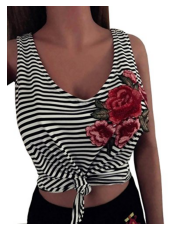

ASIN: B071WC1F83
Brand: Lily-Li
Type: SHIRT
Title: women summer casual stretchy embroidered floral cami crop tank tops 
Distance From Query Point: 0.0


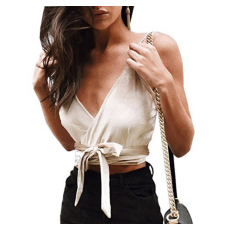

ASIN: B073FBK8ZF
Brand: Lily-Li
Type: SHIRT
Title: women crisscross vneck sexy lace up clubwear evening party cami tank crop top 
Distance From Query Point: 1.2134179251534598


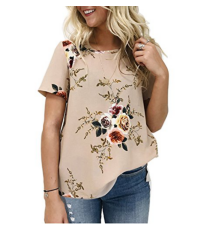

ASIN: B0722Q5181
Brand: Lily-Li
Type: SHIRT
Title: women casual loose short sleeve summer chiffon print floral blouse tops 
Distance From Query Point: 1.2244098118373326


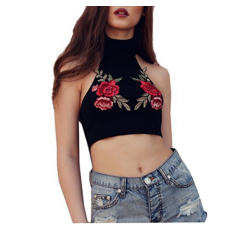

ASIN: B0711HC5WB
Brand: Lily-Li
Type: SHIRT
Title: women sexy embroidered floral backless choker halter crop top 
Distance From Query Point: 1.297785186767578


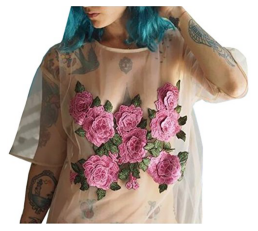

ASIN: B073PRDYM8
Brand: Lily-Li
Type: SHIRT
Title: women short sleeve loose sexy embroidered floral sheer mesh tops blouse 
Distance From Query Point: 1.306391143798828


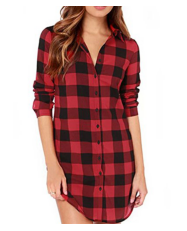

ASIN: B01I98ITVQ
Brand: Lily-Li
Type: SHIRT
Title: womens plaid long sleeve asymmetrical hem shirt tops 
Distance From Query Point: 1.3916902814592633


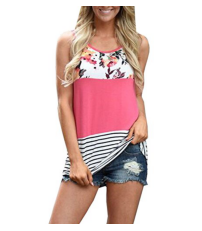

ASIN: B071WNNLLK
Brand: Lily-Li
Type: SHIRT
Title: women summer casual loose fit contrast color striped floral print back lace trim tank tops 
Distance From Query Point: 1.4475758143833706


In [ ]:
# Give low weight to tilte and equal weight to both brand and type
get_triple_distance(index = 66, title_weight = 5, brand_weight = 15, type_weight = 15, k = 7)

Here we give low weight to title and brand and high weight to type so all the result we get would prefere the same type as the query product.

Query Data:


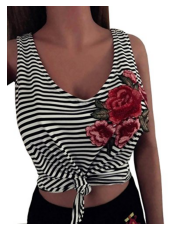

ASIN: B071WC1F83
Brand: Lily-Li
Type: SHIRT
Title: women summer casual stretchy embroidered floral cami crop tank tops 
Distance From Query Point: 0.0


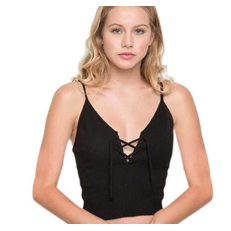

ASIN: B071HM1F33
Brand: Sumilulu
Type: SHIRT
Title: sumilulu women knitted crop tops casual cotton cami tank tops 
Distance From Query Point: 1.608382721019541


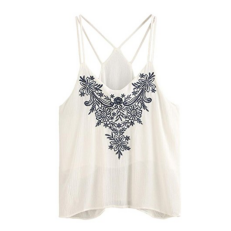

ASIN: B0725FQ9QF
Brand: bestpriceam
Type: SHIRT
Title: bestpriceam women tank tops flower embroidered strappy cami top 
Distance From Query Point: 1.6144009400136816


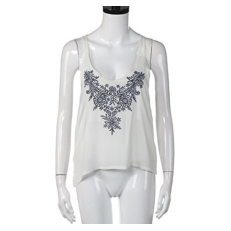

ASIN: B0716C36B7
Brand: Putars
Type: SHIRT
Title: putars women summer fashion tank tops flower embroidered strappy cami top white 
Distance From Query Point: 1.6226690674550879


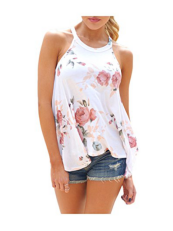

ASIN: B072JMD9YF
Brand: Sumtory
Type: SHIRT
Title: sumtory women sleeveless floral printed summer flowy tank tops 
Distance From Query Point: 1.6272032166250097


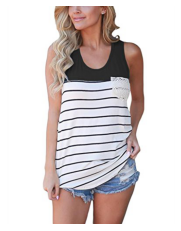

ASIN: B073GZFHR4
Brand: JomeDesign
Type: SHIRT
Title: jomedesign womens summer striped racerback casual cami tank tops 
Distance From Query Point: 1.6444458008535252


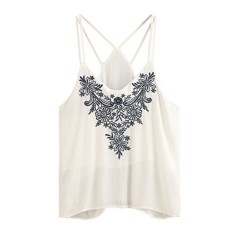

ASIN: B06XKS9MX4
Brand: Mosunx(TM)
Type: SHIRT
Title: womens tank tops mosunxtm flower embroidered strappy cami top 
Distance From Query Point: 1.6714929199941502


In [ ]:
# Give more weight to type more than title and brand
get_triple_distance(index = 66, title_weight = 5, brand_weight = 5, type_weight = 15, k = 7)

Here we give low weight to title and type and high weight to brand name so all the result we get would prefere the same brand as the query product as it's clear and for that we are applying function on the same product just to show the diffence in results if we manipulate the weights given. 

Query Data:


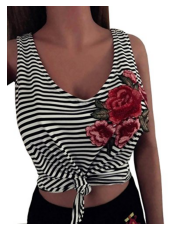

ASIN: B071WC1F83
Brand: Lily-Li
Type: SHIRT
Title: women summer casual stretchy embroidered floral cami crop tank tops 
Distance From Query Point: 0.0


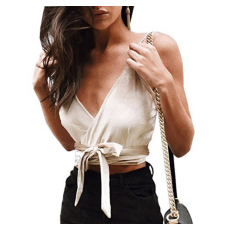

ASIN: B073FBK8ZF
Brand: Lily-Li
Type: SHIRT
Title: women crisscross vneck sexy lace up clubwear evening party cami tank crop top 
Distance From Query Point: 1.6987850952148438


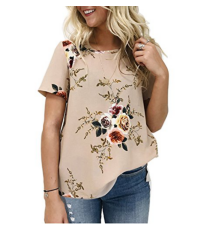

ASIN: B0722Q5181
Brand: Lily-Li
Type: SHIRT
Title: women casual loose short sleeve summer chiffon print floral blouse tops 
Distance From Query Point: 1.7141737365722656


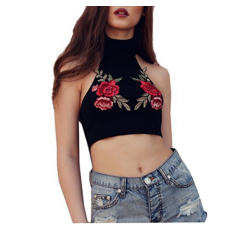

ASIN: B0711HC5WB
Brand: Lily-Li
Type: SHIRT
Title: women sexy embroidered floral backless choker halter crop top 
Distance From Query Point: 1.8168992614746093


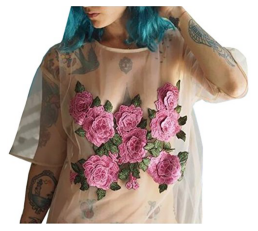

ASIN: B073PRDYM8
Brand: Lily-Li
Type: SHIRT
Title: women short sleeve loose sexy embroidered floral sheer mesh tops blouse 
Distance From Query Point: 1.8289476013183594


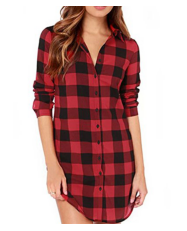

ASIN: B01I98ITVQ
Brand: Lily-Li
Type: SHIRT
Title: womens plaid long sleeve asymmetrical hem shirt tops 
Distance From Query Point: 1.9483663940429687


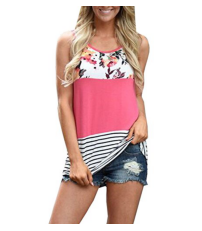

ASIN: B071WNNLLK
Brand: Lily-Li
Type: SHIRT
Title: women summer casual loose fit contrast color striped floral print back lace trim tank tops 
Distance From Query Point: 2.026606140136719


In [ ]:
# Give more weight to brand more than title and type
get_triple_distance(index = 66, title_weight = 5, brand_weight = 15, type_weight = 5, k = 7)

After that if we do mix combination of the 3 of them we may get diffrent result each time we change the weight and that finally depend of what we prefere to be our first predictor.

Query Data:


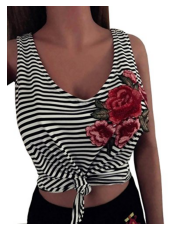

ASIN: B071WC1F83
Brand: Lily-Li
Type: SHIRT
Title: women summer casual stretchy embroidered floral cami crop tank tops 
Distance From Query Point: 0.0


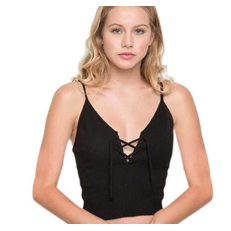

ASIN: B071HM1F33
Brand: Sumilulu
Type: SHIRT
Title: sumilulu women knitted crop tops casual cotton cami tank tops 
Distance From Query Point: 3.0424734933551965


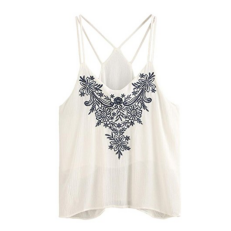

ASIN: B0725FQ9QF
Brand: bestpriceam
Type: SHIRT
Title: bestpriceam women tank tops flower embroidered strappy cami top 
Distance From Query Point: 3.055369567922719


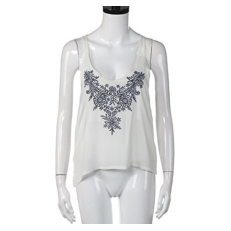

ASIN: B0716C36B7
Brand: Putars
Type: SHIRT
Title: putars women summer fashion tank tops flower embroidered strappy cami top white 
Distance From Query Point: 3.0730867658858885


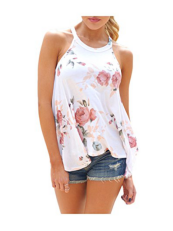

ASIN: B072JMD9YF
Brand: Sumtory
Type: SHIRT
Title: sumtory women sleeveless floral printed summer flowy tank tops 
Distance From Query Point: 3.0828031267954867


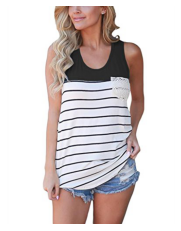

ASIN: B073GZFHR4
Brand: JomeDesign
Type: SHIRT
Title: jomedesign womens summer striped racerback casual cami tank tops 
Distance From Query Point: 3.119751412579527


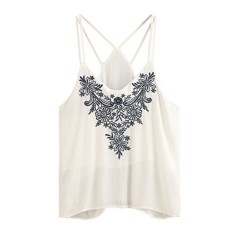

ASIN: B06XKS9MX4
Brand: Mosunx(TM)
Type: SHIRT
Title: womens tank tops mosunxtm flower embroidered strappy cami top 
Distance From Query Point: 3.1777093070410225


In [ ]:
get_triple_distance(index = 66, title_weight = 15, brand_weight = 5, type_weight = 15, k = 7)

Query Data:


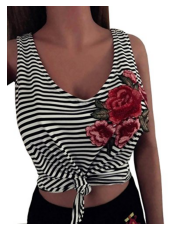

ASIN: B071WC1F83
Brand: Lily-Li
Type: SHIRT
Title: women summer casual stretchy embroidered floral cami crop tank tops 
Distance From Query Point: 0.0


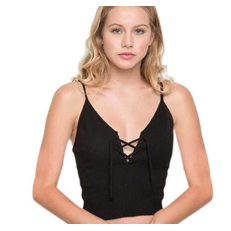

ASIN: B071HM1F33
Brand: Sumilulu
Type: SHIRT
Title: sumilulu women knitted crop tops casual cotton cami tank tops 
Distance From Query Point: 3.446534511176081


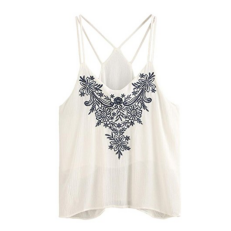

ASIN: B0725FQ9QF
Brand: bestpriceam
Type: SHIRT
Title: bestpriceam women tank tops flower embroidered strappy cami top 
Distance From Query Point: 3.459430585743603


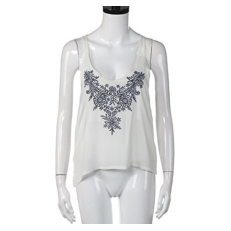

ASIN: B0716C36B7
Brand: Putars
Type: SHIRT
Title: putars women summer fashion tank tops flower embroidered strappy cami top white 
Distance From Query Point: 3.477147783706773


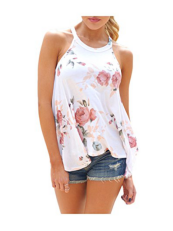

ASIN: B072JMD9YF
Brand: Sumtory
Type: SHIRT
Title: sumtory women sleeveless floral printed summer flowy tank tops 
Distance From Query Point: 3.486864144616371


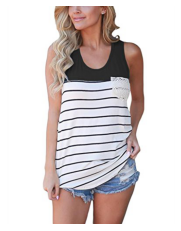

ASIN: B073GZFHR4
Brand: JomeDesign
Type: SHIRT
Title: jomedesign womens summer striped racerback casual cami tank tops 
Distance From Query Point: 3.5238124304004113


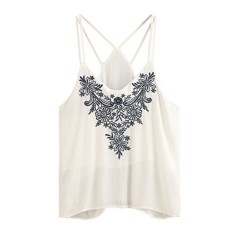

ASIN: B06XKS9MX4
Brand: Mosunx(TM)
Type: SHIRT
Title: womens tank tops mosunxtm flower embroidered strappy cami top 
Distance From Query Point: 3.581770324861907


In [ ]:
get_triple_distance(index = 66, title_weight = 15, brand_weight = 15, type_weight = 5, k = 7)

We can not prefere one model over the other, for some point some people might say that using Word2Vec is the best model, some people might say that using Tf-Idf is the best, so for that we can't decide that naively by just looking and we can even use all of them after checking some criteria in the business rules which judge such things in the industry. 

By Now we have only used text data in order to get similar product, but we can also use image data to get similar product based on their similarity with the query image, and that will be very useful because image data can make very powerful and informative feature.

We can convert each image we have into vector of feature using Deep Learing Model (CNN) and specifically using transfer learning.